# Transformer model + RPG testing pipeline

This document lays out the procedure for:
- Training the forward model to learn the RPG environment and saving it to disk
- Using the trained forward model to generate expert memories and saving them
- Loading the expert memories into the transformer model
- Training the transformer model

## Table of Contents
1. [Train the forward model](#Train-the-forward-model)
2. [Locate the saved model](#Locate-the-saved-model)
3. [Generate memories and save to disk](#Generate-memories-and-save-to-disk)
4. [Evaluate the transformer model](#Evaluate-the-transformer-model)

In [3]:
# --------------- #
# region: Imports #
# --------------- #

# Import base packages
import os
import sys
from pathlib import Path
from datetime import datetime

# Going to sorrel root
module_path = Path().resolve().parent.parent.parent
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))


from sorrel.examples.treasurehunt.entities import EmptyEntity
from sorrel.examples.treasurehunt.env import TreasurehuntEnv
from sorrel.examples.treasurehunt.world import TreasurehuntWorld
from sorrel.utils.logging import TensorboardLogger

# --------------- #
# endregion       #
# --------------- #

## Train the forward model

To give the transformer model something to learn, we need to first train a model to solve the RPG task.

To edit details of the model training regime, use the configuration file (by default, stored in `../configs/config.yaml` relative to this Python notebook) to change them. Some details need to be changed together for the model to successfully run.

In addition to providing a simple console log summary of each epoch, more detailed data is stored in TensorBoard if `log` in the configuration file is set to `True`.

In [ ]:
# Load configuration
config = {
    "experiment": {
        "epochs": 1000,
        "max_turns": 100,
        "record_period": 50,
        "log_dir": Path("../data/logs") / datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
    },
    "model": {
        "agent_vision_radius": 2,
        "epsilon_decay": 0.0005,
    },
    "world": {
        "height": 20,
        "width": 20,
        "gem_value": 10,
        "food_value": 5,
        "bone_value": -10,
        "spawn_prob": 0.01,
    },
}

# construct the world
world = TreasurehuntWorld(config=config, default_entity=EmptyEntity())

# construct the environment
env = TreasurehuntEnv(world, config)

# model save path
model_path = (
    Path("../models/checkpoints")
    / f"treasurehunt_model_{datetime.now().strftime('%Y%m%d-%H%M%S')}.pkl"
)
model_path.parent.mkdir(parents=True, exist_ok=True)

# run the experiment with default parameters
env.run_experiment(
    output_dir=Path("../data"),
    logger=TensorboardLogger.from_config(config),
)

# save model
print("\nSaving model...")
for agent in env.agents:
    agent.model.save(file_path=str(model_path))
    print(f"Model saved to: {model_path}")
    break

## Locate the saved model

Once a trained model is saved to disk, using it again is just a matter of creating a new python object with the same configurations.

```py
model_path = '/path/to/model.pkl'

model = iRainbowModel(
    ...# pass in parameters
)

model.load(model_path) # Now the model is ready to use again.
```

## Generate memories and save to disk

Generating memories of game trajectories, replays of games, and model scores on games is achieved using the `eval_model()` function. This function plays a specified number of games (by default, 1) and returns a dictionary of output variables. The memories file is somewhat large (~ 1.5 GB for 1024 games), so keep that in mind.

Flags that can be used:
- `'memories'` returns a stored memory buffer of size (n_games x max_turns)
- `'frames'` returns a list of size (n_games x max_turns) with images of each turn.
- `'scores` returns a record of the model's reward on each turn.
- `'jupyter-mode'` should be added when you are using `'frames'` from a Python notebook rather than from the command line.

**NOTE**: As generating the frames takes a while, it's generally faster to generate animated replays and memories separately.

╔═════════════╦═══════════╦═════════════╦═════════════╗
║ Epoch:    0 ║ Turn: 100 ║ Loss:  None ║ Reward:  40 ║
╚═════════════╩═══════════╩═════════════╩═════════════╝


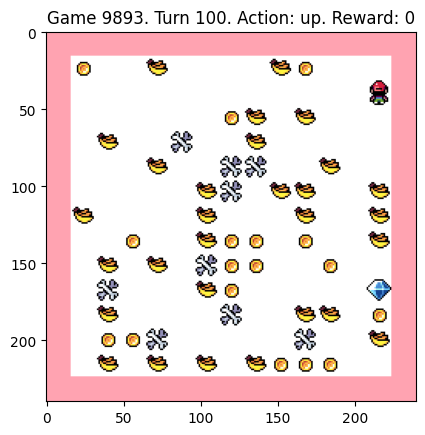

In [15]:
from examples.RPG.test import eval_model
from gem.utils import animate

model_path = "../models/checkpoints/iRainbowModel_20251018-19101760831698.pkl"

config_path = "../configs/config.yaml"

os.makedirs("../data/", exist_ok=True)

results = eval_model(
    "memories", model_path=model_path, config_path=config_path, n_games=1024
)

# Save the stored memories
memories = results["memories"]
memories_path = "../data/memories.pkl"
memories.save(file_path=memories_path)

# Replay one game
results = eval_model(
    "frames", "jupyter-mode", model_path=model_path, config_path=config_path, n_games=1
)

data_folder = "../data/"
game = results["frames"][0]
animate(game, filename="model_test", folder=data_folder)

## Evaluate the transformer model

The transformer model uses a separate configuration file (by default, `../configs/transformer.yaml`). This file is shorter and handles only the details of the transformer model itself, since all of the details of the environment were already established when training the forward model. Make sure that the input parameters are compatible with those used by the forward model.

**NOTE**: Be aware that at this stage, some specific configurations are not compatible with the transformer model. For example, the transformer model requires the state space to be evenly divisible by a patch size. Since the agent vision results in an odd-numbered state H x W, the state size in the forward model must have a H x W of e.g., 9 x 9, 15 x 15, 21 x 21 in order to have a patch size of 3.

In [16]:
from examples.RPG.test import train_transformer_model

# Load configuration path
transformer_config_path = "../configs/transformer.yaml"
cfg = load_config(argparse.Namespace(config=transformer_config_path))

# Train the transformer model
train_transformer_model(cfg, memories_path=memories_path)

Epoch 99. Total training duration: 35.427072048187256.


Generating Memories for second agent

In [7]:
from examples.RPG.test import eval_model
from gem.utils import animate

model_path = "../models/checkpoints/iRainbowModel_20251018-19101760831698.pkl"

config_path = "../configs/config.yaml"

os.makedirs("../data/", exist_ok=True)

results_agent_2 = eval_model(
    "memories",
    model_path=model_path,
    config_path=config_path,
    n_games=1024,  # Using less for testing
    # Seed is already randomized
)

# Save the stored memories
memories_agent_2 = results_agent_2["memories"]
memories_path_agent_2 = "../data/memories_agent_2.pkl"
memories_agent_2.save(file_path=memories_path_agent_2)

**Simple test to validate weight transfer hypothesis**

In [1]:
import torch
import argparse
from examples.RPG.main import load_config
from gem.models.transformer import VisionTransformer
from gem.models.buffer import ReplayBuffer
import numpy as np

# Load configs
transformer_config_path = "../configs/transformer.yaml"
cfg = load_config(argparse.Namespace(config=transformer_config_path))

# Loading memories for both agents
buffer_agent_1 = ReplayBuffer.load("../data/memories.pkl")
buffer_agent_2 = ReplayBuffer.load("../data/memories_agent_2.pkl")

# Creating model

model = VisionTransformer(
    state_size=cfg.model.state_size,
    action_space=cfg.model.action_space,
    layer_size=cfg.model.layer_size,
    patch_size=cfg.model.patch_size,
    num_frames=cfg.model.num_frames,
    batch_size=cfg.model.batch_size,
    num_layers=cfg.model.num_layers,
    num_heads=cfg.model.num_heads,
    memory=buffer_agent_1,  # Start with agent 1
    LR=cfg.model.LR,
    device=cfg.model.device,
    seed=cfg.model.seed,
)

print(f"Model created on {cfg.model.device}")

# TEST 1: Self-Prediction

print("TEST 1: SELF PREDICTION\n")

model.memory = buffer_agent_1
train_steps = 10  # 500

print(f"\nTraining for {train_steps} steps:")
train_losses = []
for step in range(train_steps):
    state_loss, action_loss = model.train_model()
    train_losses.append((state_loss, action_loss))

    if step % 1 == 0:
        total = state_loss + action_loss
        print(
            f"  Step {step:3d}: State={state_loss:.4f}, Action={action_loss:.4f}, Total={total:.4f}"
        )

print(f"\nDEBUG INFO:")
print(f"Batch size: {model.batch_size}")
print(f"Memory size: {len(model.memory)}")
print(f"Can sample: {len(model.memory) >= model.batch_size}")

# Evaluating on Agent 1 (self)
print("\nEvaluating on Agent 1:")
model.eval()
eval_losses_agent_1 = []
for _ in range(5):  # 20 evaluation batches
    state_loss, action_loss = model.train_model()
    eval_losses_agent_1.append(state_loss + action_loss)
model.train()

avg_loss_agent_1 = np.mean(eval_losses_agent_1)
print(f"Agent 1 Evaluation Loss: {avg_loss_agent_1:.4f}")

# TEST 2: Cross-Agent Transfer (Evaluating on agent 2)

print("TEST 2: CROSS AGENT TRANSFER\n")

model.memory = buffer_agent_2

print("\nEvaluating on Agent 2:")
model.eval()
eval_losses_agent_2 = []
for _ in range(5):  # 20 evaluation batches
    state_loss, action_loss = model.train_model()
    eval_losses_agent_2.append(state_loss + action_loss)
model.train()

avg_loss_agent_2 = np.mean(eval_losses_agent_2)
print(f"Agent 2 Evaluation Loss: {avg_loss_agent_2:.4f}")


# RESULTS

print("RESULTS\n")

print(f"\nLoss Comparison:")
print(f"Agent 1 (trained on): {avg_loss_agent_1:.4f}")
print(f"Agent 2 (transfer to): {avg_loss_agent_2:.4f}")

transfer_gap = (avg_loss_agent_2 - avg_loss_agent_1) / avg_loss_agent_1 * 100
print(f"\nTransfer Gap: {transfer_gap:+.1f}%")

Model created on cpu
TEST 1: SELF PREDICTION


Training for 10 steps:
  Step   0: State=0.8054, Action=1.8242, Total=2.6296
  Step   1: State=0.7942, Action=1.6624, Total=2.4567
  Step   2: State=0.7835, Action=1.5185, Total=2.3020
  Step   3: State=0.7736, Action=1.3947, Total=2.1683
  Step   4: State=0.7646, Action=1.2920, Total=2.0566
  Step   5: State=0.7562, Action=1.2101, Total=1.9663
  Step   6: State=0.7485, Action=1.1469, Total=1.8954
  Step   7: State=0.7413, Action=1.0996, Total=1.8409
  Step   8: State=0.7344, Action=1.0647, Total=1.7991
  Step   9: State=0.7277, Action=1.0389, Total=1.7667

DEBUG INFO:
Batch size: 8
Memory size: 1024
Can sample: True

Evaluating on Agent 1:
Agent 1 Evaluation Loss: 1.7008
TEST 2: CROSS AGENT TRANSFER


Evaluating on Agent 2:
Agent 2 Evaluation Loss: 3.8146
RESULTS


Loss Comparison:
Agent 1 (trained on): 1.7008
Agent 2 (transfer to): 3.8146

Transfer Gap: +124.3%
